# Лабораторная работа 10. Динамическое программирование.

In [1]:
import networkx as nx
import pylab
import numpy as np
import time
import matplotlib.pyplot as plt

# Пример №1. Числа Фибоначчи

Последовательность чисел Фибоначчи задаётся рекуррентным выражением:

$$ F_n =  \begin{cases}
           0, n = 0, \\
           1, n = 1, \\
           F_{n-1}+F_{n-2}, n > 1.
          \end{cases} $$

Что даёт следующую последовательность {0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …}.

Один из способов решения, который может показаться логичным и эффективным, — решение с помощью рекурсии:

In [2]:
def Fibonacci_Recursion(n):
    if n == 0:
        return 0
    if n == 1:
        return 1
    return Fibonacci_Recursion (n-1) + Fibonacci_Recursion (n-2)

Используя такую функцию, мы будем решать задачу «с конца» — будем шаг за шагом уменьшать n, пока не дойдем до известных значений.

Но, как мы видели ранее эта реализация многократно повторяет решение одних и тех же задач. Это связано с тем, что одни и те же промежуточные данные вычисляются по несколько раз, а число операций нарастает с той же скоростью, с какой растут числа Фибоначчи — экспоненциально.

Один из выходов из данной ситуации — сохранение уже найденных промежуточных результатов с целью их повторного использования (кеширование). Причём кеш должен храниться во внешней области памяти.

In [3]:
def Fibonacci_Recursion_cache(n, cache):
    if n == 0:
        return 0
    if n == 1:
        return 1
    if cache[n] > 0:
        return cache[n]
    cache[n] = Fibonacci_Recursion_cache (n-1, cache) + Fibonacci_Recursion_cache (n-2, cache)
    return cache[n]

Приведенное решение достаточно эффективно (за исключением накладных расходов на вызов функций). Но можно поступить ещё проще:

In [4]:
def Fibonacci(n):
    
    fib = [0]*max(2,n)
    fib[0] = 1
    fib[1] = 1
    for i in range(2, n):
        fib[i] = fib[i - 1] + fib[i - 2]
        
    return fib[n-1]

Такое решение можно назвать решением «с начала» — мы первым делом заполняем известные значения, затем находим первое неизвестное значение, потом следующее и т.д., пока не дойдем до нужного.

Так и работает динамическое программирование: сначала решили все подзадачи (нашли все F[i] для i < n), затем, зная решения подзадач, нашли решение исходной задачи.

Проверим правильность работы этих программ:

In [5]:
N = 9
cache = [0]*(N+1)
assert Fibonacci_Recursion(N) == 34
assert Fibonacci_Recursion_cache(N, cache) == 34
assert Fibonacci(N) == 34

И их производительность:

In [6]:
n=25
a = np.zeros(n)
cache = [0]*(n+1)

In [7]:
start_time = time.time()
for i in range (n): a[i] = Fibonacci_Recursion(i)
print('%-28s %12.6e sec' % ('Fibonacci_Recursion:', time.time()-start_time))

start_time = time.time()
for i in range (n): 
    cache = [0]*(i+1)
    a[i] = Fibonacci_Recursion_cache(i,cache)
print('%-28s %12.6e sec' % ('Fibonacci_Recursion_cache:', time.time()-start_time))
    
start_time = time.time()
for i in range (n): a[i] = Fibonacci(i)
print('%-28s %12.6e sec' % ('Fibonacci:', time.time()-start_time))

Fibonacci_Recursion:         5.965996e-02 sec
Fibonacci_Recursion_cache:   2.503395e-04 sec
Fibonacci:                   1.611710e-04 sec


# Пример №2. Задача о возрастающей подпоследовательности

Пусть имеется последовательность чисел $a_1, a_2, … a_N$. Подпоследовательность $a_{i_1}, a_{i_2}, a_{i_3}$, ... называется возрастающей, если
$$ 1 < i_1 < i_2 < ... < i_k < n $$
и
$$ a_{i_1} < a_{i_2} < ... < a_{i_k} $$
Требуется найти максимальную длину возрастающей подпоследовательности. Например, для последовательности $a_i = {10, 4, 13, 7, 3, 6, 17, 33}$ одна из возрастающих подпоследовательностей есть ${4, 7, 17, 33}$.

В этой задаче длина наибольшего пути к вершине i (уравнение Беллмана) есть максимум из наибольших путей к предыдущим вершинам плюс единица:
$$ L_i = 1 + max(L_{i-1, j}, j = 1, N_{L_{i-1}}) $$.

In [19]:
def f(a, k):
    # k - номер конечного элемента
    m=0
    for i in range(k):      # для всех слева
        if (a[i] < a[k]):   # есть путь?
            p = f(a,i)      # его длина
            print('p',p)
            print('m',m)
            if (p>m): m=p   # m = max(m,p)
    return m+1

In [27]:
a = [1, 4, 2, 5, 3]
f(a,3)

p 1
m 0
p 1
m 0
p 2
m 1
p 1
m 0
p 2
m 2


3

Чтобы повторно не решать решённые подзадачи, введём массив c размером N, хранящий значения вычисленных функций. Начальные значения его равны нулю — значению, которое не может быть верным решением любой из подзадач. Это позволит нам определить, решали ли мы эту подзадачу или нет. Если нет — запускаем решение для требуемого аргумента, и после получения результата сохраняем его.

In [28]:
def f(a, N, k, cache):
    # k - номер конечного элемента
    if(cache[k]!=0): return cache[k]
    m=0
    for i in range(k-1):          # для всех слева
        if (a[i] < a[k]):         # есть путь?
            p = f(a,N,i,cache)    # его длина
            if (p>m): m=p         # m = max(m,p)
    cache[k] = m+1
    return cache[k]

In [30]:
c = [0]*5
a = [1, 4, 2, 5, 3]
f(a,5,4,c)

3

# Пример №3. Задача о банкомате

Если в задаче о рюкзаке сделать варианты предметов неисчерпаемыми можно перейти к задаче о банкомате. 
Постановка: В банкомате имеется неограниченное количество банкнот (b1, b2, . . . , bn) заданных номиналов. Нужно выдать требуемую сумму денег наименьшим количеством банкнот.
Как мы уже выяснили, жадное решение возможно не для всех наборов входных данных. Например, при b = {1, 6, 10} и x = 12 жадное решение даст ответ 3 (10 + 1 + 1), хотя существует более оптимальное решение 2 (6 + 6). 
Сделаем задачу о банкомате похожей на задачу о количестве маршрутов.

Для каждой суммы проведём стрелку к узлу с новой разрешённой суммой. Уравнение Беллмана:

$$ f(x) =  \begin{cases}
            min(f(x-b_i))+1, x > 0 \\
            \quad 0 \quad, x = 0 \\
            \quad \infty \quad, x < 0
           \end{cases} $$

In [31]:
googol = 999999999
def f(x,b,n,cache):
    if (x<0): return googol
    elif(x==0): return 0
    elif(cache[x]>=0): return cache[x]
    minim = googol
    for i in range(n):
        r = f(x-b[i],b,n, cache)
        if (r<minim): minim=r
    cache[x] = minim + 1
    return cache[x]

In [32]:
cache = [-1]*10
b = [1, 4, 6]
f(9,b,3,cache)

3

Доведя решение задачи до ответа и имея кэш-таблицу, можно восстановить решение без дополнительной информации.
Предположим, что мы знаем, что точный ответ при заданных начальных значениях есть 7. Тогда возникает вопрос: какой предыдущий ход мы сделали, чтобы попасть в заключительную позицию? Введём термин ранг для обозначения наименьшего числа ходов, требуемого для достижения текущей позиции из начальной. Тогда каждый ход решения всегда переходит в позицию с рангом, большим строго на единицу, и это позволяет нам придумать следующий алгоритм:

1. решение основной задачи дало в ответе k, это — ранг заключительной позиции,
2. делаем позицию текущей,
3. если текущая позиция имеет ранг 0, то это — начальная позиция и алгоритм завершён,
4. рассматриваем позиции, ведущие в текущую, и выбираем из них произвольную с рангом k − 1,
5. запоминаем ход, который привёл из позиции ранга k − 1 в ранг k,
6. понижаем ранг – k → k − 1 и переходим к 2.

In [33]:
def buildSolution(x, b, n, cache):
    ret = []
    for k in range (cache[x],-1,-1):
        for i in range(n):
            r = x - b[i]
            if (r >= 0 and cache[r] == k-1):
                x = r
                ret.append(b[i])
                break
    return ret

In [34]:
buildSolution(9, b, 3, cache)

[1, 4, 4]

# Пример №4. Задача о кузнечике.

Рассмотрим следующую задачу. На числовой прямой сидит кузнечик, который может прыгать вправо на одну или на две единицы. Первоначально кузнечик находится в точке с координатой 1. Определите количество различных маршрутов кузнечика, приводящих его в точку с координатой n.

Обозначим количество маршрутов кузнечика, ведущих в точку с координатой n, как K[n]. Прежде всего заметим, что существует ровно один маршрут из точки 1 в точку 1 — он не содержит ни одного прыжка. В точку 2 можно прыгнуть единственным способом — из точки 1.

Как вычислить K[n]? В точку кузнечик может попасть двумя способами — из точки при помощи прыжка длиной 2 и из точки прыжком длины 1. То есть число способов попасть в точку n равно сумме числа способов попасть в точку (n-1) и (n-2), что позволяет выписать рекуррентное соотношение: 

$$K[n] = K[n-1] + K[n-2]$$.

Можно заметить, что данная задача по сути свелась к числам Фибоначчи, поэтому мы не будем выписывать её решение.

# Упражнение №1

Решите задачу о количестве способов достичь точки n из точки 1, если кузнечик умеет прыгать +1, +2 и +3.

In [36]:
def grasshopper(n):
    GH = [0] * max(3, n)
    GH[0] = 0 # уже в первой точке
    GH[1] = 1
    GH[2] = 2
    for i in range(3, n):
        GH[i] = GH[i - 1] + GH[i - 2] + GH[i - 3]
    return GH[n - 1]


In [37]:
grasshopper(8)

37

# Упражнение №2 Задача о кузнечике со стоимостями посещения точек

Пусть кузнечик прыгает на одну или две точки вперед, а за прыжок в каждую точку необходимо заплатить определенную стоимость, различную для различных точек. Стоимость прыжка в точку i задается значением price[i] списка price. Необходимо найти минимальную стоимость маршрута кузнечика из точки 0 в точку n.

На этот раз нам необходимо модифицировать определение целевой функции. Пусть C[n] — минимальная стоимость пути из 1 в n.

Выведем рекуррентное соотношение для этой функции.Чтобы попасть в точку n мы должны попасть в неё последним прыжком из (n-1) или (n-2). Минимальные стоимости этих маршрутов будут равны С[n-1] и С[n-2] соответственно, к ним придется добавить значение price[n] за прыжок в клетку n. Но из двух клеток мы можем выбрать любую.

Нужно выбрать тот маршрут, который имеет наименьшую стоимость. Ур. Беллмана: 

$$C[n] = min(C[n-1], C[n-2]) + price[n]$$.

Вычислить значение целевой функции также лучше при помощи динамического программирования, а не рекурсии.

Напишите функцию вычисления наименьшей стоимость достижения клетки n из клетки 1

In [38]:
def grasshopperWithCost(n, prices):
    if len(prices) < 2:
        return
    costs = [0] * max(2, n + 1)
    costs[0] = 0
    costs[1] = prices[0]
    for i in range(2, n + 1):
        costs[i] = min(costs[i - 1], costs[i - 2]) + prices[i - 1]
    return costs[n]

In [40]:
prices = list(map(float, input('Введите через пробел стоимости попадания в точки 2 - N: ').split()))

Введите через пробел стоимости попадания в точки 2 - N: 5 3 4 2 1


In [41]:
try:
    k = int(input('Введите точку, в которую нужно рассчитать маршрут минимальной стоимости: ')) - 1
    if not 1 <= k < len(prices) + 1:
        print('Не назначена стоимость пути до точки.')
    else:
        print('Стоимость пути равна', grasshopperWithCost(k, prices))
except:
    print('Точка должна быть обозначена целым числом от 1 до N.')

Введите точку, в которую нужно рассчитать маршрут минимальной стоимости: 4
Стоимость пути равна 7.0


# Упражнение №3 Восстановление наиболее выгодной траектории
Итак, мы нашли список С, где будет записана минимальная стоимость маршрута для всех точек от 1 до n.

Но помимо нахождения наименьшей стоимости маршрута, разумеется, хотелось бы найти и сам маршрут минимальной стоимости. Такая задача называется задачей «восстановления ответа».

Для восстановления ответа будем для каждой точки запоминать номер точки prev[i], из которой кузнечик попал в точку i, если он будет передвигаться по пути минимальной стоимости. То есть prev[i] — это точка, предшествующая точке с номером i на пути минимальной стоимости (также говорят, что Prev — это массив предшественников). Как определить prev[i]? Если C[i-1] < C[i-2], то кузнечик попал в точку i из точки (i-1), поэтому prev[i] = i - 1, иначе prev[i] = i - 2.

Для восстановления пути необходимо начать с точки n и переходить от каждой точки к ее предшественнику, пока путь не дойдет до начальной точки с номером 0. Номера всех вершин будем добавлять в список path. В конце в список path добавляется начальная вершина номер 1, которая не была обработана в основном цикле, а затем весь список path разворачивается в обратном порядке (т. к. вершины добавляются в обратном порядке, от конечной к начальной).

Модифицируйте алгоритм вычисления значений целевой функции так, чтобы вычислить значения prev[i], и восстановите траекторию наименьшей стоимости из точки 1 в точку n.

In [42]:
def grasshopperWithCostAndPath(n, prices):
    if len(prices) < 2:
        print('')
        return
    if n == 1:
        return 0, []
    elif n == 2:
        return prices[0], [1]
    paths = []
    costs = [0] * max(2, n + 1)
    costs[0] = 0
    costs[1] = prices[0]
    paths.append([])
    paths.append([1])
    for i in range(2, n):
        if costs[i - 1] >= costs[i - 2]:
            costs[i] = costs[i - 2] + prices[i - 1]
            paths.append(paths[i - 2] + [i - 1])
        else:
            costs[i] = costs[i - 1] + prices[i - 1]
            paths.append(paths[i - 1] + [i])
    return costs[n - 1], paths[n - 1]

In [44]:
prices = list(map(float, input('Введите через пробел стоимости попадания в точки 2 - N: ').split()))

Введите через пробел стоимости попадания в точки 2 - N: 6 2 5 1 4


In [50]:
try:
    k = int(input('Введите точку, в которую нужно рассчитать маршрут минимальной стоимости: '))
    if not 0 < k <= len(prices) + 1:
        print('Не назначена стоимость пути до точки.')
    else:
        cost, path = grasshopperWithCostAndPath(k, prices)
        print('Стоимость пути равна ' + str(cost) + '.')
        print('Путь: ', end='')
        for i in range(len(path)):
            print(path[i], end=' -> ')
        print(k)
except:
    print('Точка должна быть обозначена целым числом от 1 до N.')

Введите точку, в которую нужно рассчитать маршрут минимальной стоимости: 5
Стоимость пути равна 3.0.
Путь: 1 -> 3 -> 5


In [46]:
def onlyPathDefinderForOptimalCost(dot, prices):
    # по условию путь оптимален, так как его стоимость минимальна
    prices = [0] + prices
    price = prices[dot]
    while dot > 1:
        if prices[dot - 1] >= prices[dot - 2]:
            price += prices[dot - 2]
            dot -= 2
        else:
            price += prices[dot - 1]
            dot -= 1
    return price

In [49]:
print('Стоимость пути равна:', 
      onlyPathDefinderForOptimalCost(int(input('Введите точку, из которой хотите ' +
                                               'рассчитать оптимальную стоимость: ')) - 1, prices))

Введите точку, из которой хотите рассчитать оптимальную стоимость: 4
Стоимость пути равна: 7.0


# Пример №5. Расстояние редактирования

Часто текстовый редактор, подозревая опечатку, предлагает заменить написанное слово на близкое. Что значит «близкое»? 

Количество операций для превращения одного слова в другое называется расстоянием редактирования или расстоянием Левенштейна (ИПМ им. Келдыша). Это расстояние — мера различия между двумя строками. Этой мерой измеряют сходство или различие двух генных последовательностей и т.д.
Задача. Определить минимальное количество операций для преобразования одного слова в другое, при следующих допустимых операциях:
- замена одной буквы на другую;
- вставка одной буквы;
- удаление одной буквы.

Например, сколько нужно операций, чтобы превратить слово СЛОН в слово ОГОНЬ? Например, это можно сделать следующей последовательностью:
СЛОН → СГОН → СГОНЬ → ОГОНЬ.
Последовательность переходов, которую мы описали, не обладает нужными свойствами (последовательным увеличением сложности задачи).А есть ли нужная нам последовательность, в которой каждая подзадача решается на подстроке всё более возрастающей длины? Конечно:
1. В префиксах строк длины 1 С и О меняем букву С на О. СЛОН → ОЛОН.
2. В префиксах длины 2 меняем Л на Г. ОЛОН → ОГОН.
3. В префиксах длины 4 добавляем букву Ь. ОГОН → ОГОНЬ.

И так, необходимо найти расстояние редактирования между $x[1...m]$ и $y[1...n]$. Будем искать расстояние редактирования между префиксами первой строки, $x[1...i]$, и префиксами второй, $y[1...j]$, обозначив эти расстояния $E[i,j]$. Конечная цель – вычисление $E[m, n]$.

Например, $E[7,5]$:
$$ \fbox{E X P O N E N} T I A L $$
$$ \fbox{P O L Y N} O M I A L $$

Значения $E[i,j]$ удобно представлять в виде таблицы. Для удобства добавим один лишний левый столбеци одну лишнюю верхнюю строку к этой таблице. Заполним их последовательно возрастающими числами. Эти числа означают, что пустая строка может превратиться в образец за число операций, равное длине образца. 

Очевидно, что при такой записи в каждуюследующую клетку можно попасть только из левой, верхне или по диагонали из левой верхне. При этом из этих вариантов выбирается минимальный и к нему прибавляются затраты на новое редактирование: 0 - если на пересечении текущего столбца и строки стоят одинаковые буквы и 1 - если разные. Т.е. ур. Беллмана:

$$ E[i,j] = min(1 + E[i-1, j], 1 + E[i, j-1], d(i, j) + E[i-1, j-1]), $$
$$ d(i, j) = \begin{cases}
                 0, x[i] = y[j] \\
                 1, x[i] \neq y[j]
                 \end{cases} $$

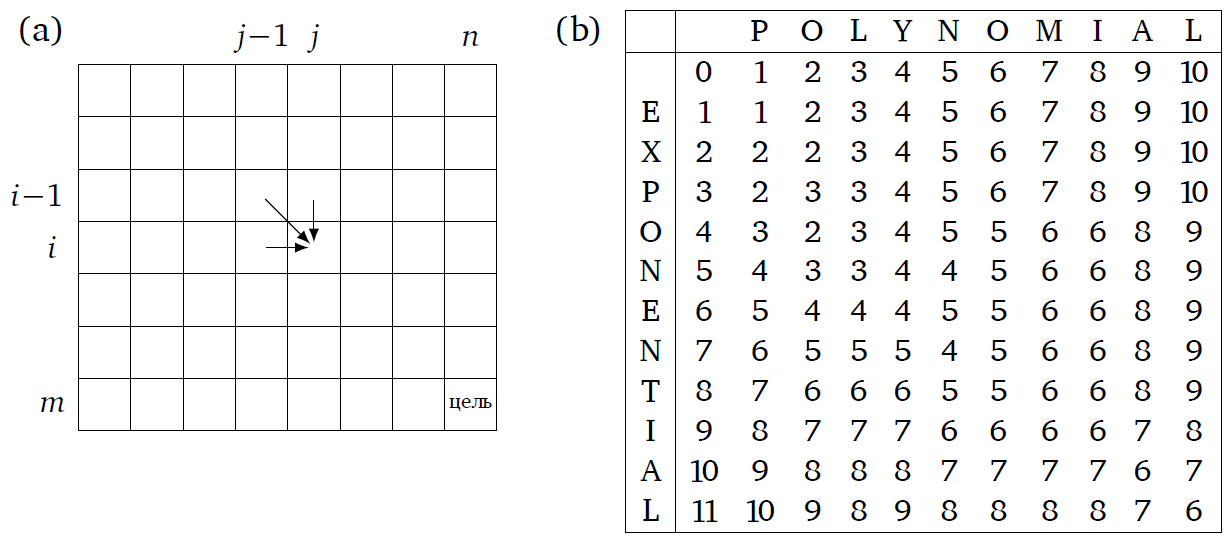

In [ ]:
# Так можно добавлять картинки

from IPython.display import Image             # вызов из библиотеки определённой функции
Image("Расстояние редактирования.png")        # вызов функции и передача ей в качестве аргумента пути к файлу 

# (в данном случае фаил находится в той же папке)

# Упражнение №4.

Напишите программу вычисляющую расстояние редактирования.

In [51]:
def IDONTKNOWWHATISTHISBUTIMAFRAIDOFTHISBULLSHIT(first, second):
    E = np.zeros((len(first) + 1, len(second) + 1))
    # начальное заполнение матрицы
    for i in range(1, len(first) + 1):
        E[i][0] = i
    for j in range(1, len(second) + 1):
        E[0][j] = j
    for j in range(1, len(second) + 1):
        for i in range(1, len(first) + 1):
            E[i][j] = min(1 + E[i - 1][j],
                          1 + E[i][j - 1],
                          int(not first[i - 1] == second[j - 1]) + E[i - 1][j - 1])
    print(E)
    return E[len(first)][len(second)]

In [52]:
print(IDONTKNOWWHATISTHISBUTIMAFRAIDOFTHISBULLSHIT('фонарь', 'улица'))

[[0. 1. 2. 3. 4. 5.]
 [1. 1. 2. 3. 4. 5.]
 [2. 2. 2. 3. 4. 5.]
 [3. 3. 3. 3. 4. 5.]
 [4. 4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6. 6.]]
6.0


# Домашнее задание (базовое):

# Задание №1. Гиперкузнечик.

Решите задачу о количестве способов достичь точки n из точки 1, если кузнечик умеет прыгать +1, +2 и *3.

In [53]:
def HYPERgrasshopper(n):
    GH = [None] + ([0] * max(3, n))
    GH[1] = 1
    GH[2] = 1
    for i in range(3, n + 1):
        GH[i] = GH[i - 1] + GH[i - 2]
        if i % 3 == 0:
            GH[i] += GH[i // 3]
    return GH[n]

In [55]:
print('Количество способов достичь её:',
      HYPERgrasshopper(int(input('Введите конечную точку: '))))

Введите конечную точку: 6
Количество способов достичь её: 12


# Задание №2. Наибольшая общая подпоследовательность.

Рассмотрим две строки (или числовые последовательности) A и B. Пусть первая строка состоит из n символов $a_0, ... a_n$, вторая строка состоит из m символов $b_0, ..., b_m$. Подпоследовательностью данной строки (последовательности) называется некоторое подмножество символов исходной строки, следующих в том же порядке, в котором они идут в исходной строке, но не обязательно подряд. Если в строке n символов, то у нее $2^n$ различных подпоследовательностей: каждый из n символов строки может либо входить, либо не входить в любую выбранную подпоследовательность. Пустая подпоследовательность не содержит ни одного элемента и также является подпоследовательностью любой строки.

Рассмотрим задачу для двух данных строк найти такую строку наибольшей длины, которая была бы подпоследовательностью каждой из них. Например, если A='abcabaac', B='baccbca' то у строк A и B них есть общая подпоследовательность длины 4, например, 'acba' или 'acbc'.

Данную задачу можно решить перебором  например, перебрав все $2^n$ подпоследовательностей первой строки и для каждой их них проверив, является ли она подпоследовательностью второй строки. Но при помощи динамического программирования эту же задачу можно решить за сложность O(nm).

Напишите программу решающую данную задачу с помощью алгоритма, полученного на основе динамического программирования. 

In [56]:
def maxCommonSequence(first, second):
    commonSequences = []
    i = 0
    while i < len(first) - 1:
        j = 0
        while j < len(second) - 1:
            if first[i] == second[j]:
                if first[i + 1] == second[j + 1]:
                    commonSequences.append(first[i])
                    commonSequences[-1] += first[i + 1]
                    i1 = i + 2
                    j1 = j + 2
                    while (i1 < len(first)) and (j1 < len(second)):
                        if first[i1] == second[j1]:
                            commonSequences[-1] += first[i1]
                        else:
                            break
                        i1 += 1
                        j1 += 1
            j += 1
        i += 1
    if len(commonSequences) == 0:
        return ''
    else:
        mx = 0
        for i in range(1, len(commonSequences)):
            if len(commonSequences[mx]) < len(commonSequences[i]):
                mx = i
        return commonSequences[mx]

In [57]:
def maxCommonSequence_Dynamically(first, second):
    first.insert(0, '1')
    second.insert(0, '2')
    E = np.zeros((len(first) + 1, len(second) + 1))
    H = np.zeros((len(first) + 1, len(second) + 1))
    for j in range(1, len(second) + 1):
        for i in range(1, len(first) + 1):
            if first[i - 1] == second[j - 1]:
                E[i][j] = 1 + E[i - 1][j - 1]
                H[i][j] = -1
            else:
                if E[i - 1][j] >= E[i][j - 1]:
                    E[i][j] = E[i - 1][j]
                    H[i][j] = 2 #l
                else:
                    E[i][j] = E[i][j - 1]
                    H[i][j] = 1 #u
    # теперь восстановим подпоследовательность с помощью H:
    i = len(first)
    j = len(second)
    commonSequences = []
    commonSequence = ''
    while H[i][j] != 0:
        if H[i][j] == -1:
            commonSequence += first[i - 1]
            i -= 1
            j -= 1
        elif H[i][j] == 1:
            if commonSequence != '':
                commonSequence
                commonSequences.append(commonSequence)
                commonSequence = ''
            j -= 1
        elif H[i][j] == 2:
            if commonSequence != '':
                commonSequences.append(commonSequence)
                commonSequence = ''
            i -= 1
    # ну, отберём 
    if len(commonSequences) == 0:
        return
    else:
        mx = 0
        for i in range(1, len(commonSequences)):
            if len(commonSequences[mx]) < len(commonSequences[i]):
                mx = i
        CS = list(commonSequences[mx])
        CS.reverse()
        CS = ''.join(CS)
        return CS

In [58]:
print(maxCommonSequence(list(str(input('Введите первую последовательность: '))), 
                        list(str(input('Введите вторую последовательность: ')))))

Введите первую последовательность: wwwtrtt
Введите вторую последовательность: efwwwqtrt
www


In [59]:
print(maxCommonSequence_Dynamically(list(str(input('Введите первую последовательность: '))),
                                    list(str(input('Введите вторую последовательность: ')))))

Введите первую последовательность: wwwtrtt
Введите вторую последовательность: efwwwqtrt
www


# Задание №3. 

Даны две последовательности целых чисел $a_0, ... a_n$ и $b_0, ..., b_m$. Выяснить, является ли вторая последовательность подпоследовательностью первой, то есть можно ли из первой вычеркнуть некоторые члены так, чтобы осталась вторая.

In [60]:
def isSecondSequenceASubsequence(first, second):
    l, k = 0, 0 # length of curr subseq and index of last found char
    j = 0
    i = 0
    while i < len(first):
        if first[i] == second[j]:
            k = i
            l += 1
            i += 1
            if j < len(second) - 1:
                j += 1
            elif l < len(second):
                return False
        else:
            i += 1
        if l == len(second):
            return True
    return False

In [63]:
print('Является ли вторая последовательность подпоследовательностью первой? Ответ:', 
      isSecondSequenceASubsequence(str(input('Введите первую последовательность: ')), 
                                   str(input('Введите вторую последовательность: '))))

Введите первую последовательность: ew466jjl
Введите вторую последовательность: 466
Является ли вторая последовательность подпоследовательностью первой? Ответ: True


# Задание №4. Мячик на лесенке.

На вершине лесенки, содержащей N ступенек, находится мячик, который начинает прыгать по ним вниз, к основанию. Сначала мячик может прыгнуть максимум на N/2, но с каждым ударом о ступеньку эта величина сокращается вдвое пока он не начинает катиться, перекатываясь с одной ступеньке на другую. Так мячик может прокатиться ещё N/16 ступенек. 

Определите число всевозможных "маршрутов" мячика и найдите максимально возможную длину лестницы N.

In [64]:
def ballOnStairs(init, n, step, show = False):
    if init >= n:
        return 0
    if n // 2 ** step < 1:
        return min(n // 16, n - init)
    routes = min(n // 2 ** step, n - init)
    for i in range(init + 1, min(init + n // 2 ** step, n) + 1):
        if show: print(init, '->', i)
        routes += ballOnStairs(i, n, step + 1, show)
    return routes

In [65]:
ballOnStairs(1, 4, 1, show = True)

1 -> 2
2 -> 3
1 -> 3
3 -> 4


4

In [66]:
ballOnStairs(1, 8, 1)

20

In [67]:
ballOnStairs(1, 16, 1)

231

In [68]:
print(ballOnStairs(1, int(input('Введите n: ')), 1, 
                   show = (True if input('Показывать все возможные ходы? (y/n) ') == 'y' 
                           else False)))

Введите n: 4
Показывать все возможные ходы? (y/n) y
1 -> 2
2 -> 3
1 -> 3
3 -> 4
4


# Домашнее задание (дополнительное):

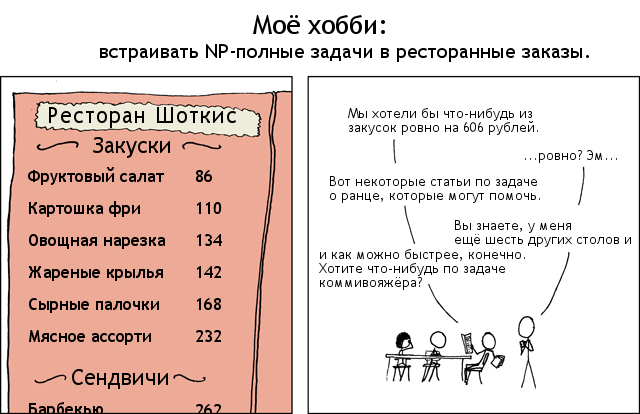

In [ ]:
# Так можно добавлять картинки

from IPython.display import Image # вызов из библиотеки определённой функции
Image("официант.png")             # вызов функции и передача ей в качестве аргумента пути к файлу 

# (в данном случае фаил находится в той же папке)

# Задача о рюкзаке.

Решите задачу о рюкзаке методом динамического программирования.

Естественно важно правильно выбрать подзадачи. В данном случае есть два естественных способа: рассмотреть рюкзак меньшей ёмкости или же меньшее число предметов. 

Для того чтобы понять, какой подход действительно работает, обычно приходится немного поэкспериментировать.

In [75]:
stuffdict = {'couch_s':(300,75), 
             'couch_b':(500,80), 
             'bed':(400,100), 
             'closet':(200,50), 
             'bed_s':(200,40), 
             'desk':(200,70), 
             'table':(300,80),
             'tv_table':(200,30),
             'armchair':(100,30),
             'bookshelf':(200,60), 
             'cabinet':(150,20),
             'game_table':(150,30),
             'hammock':(250,45),
             'diner_table_with_chairs':(250,70),
             'stools':(150,30),
             'mirror':(100,20),
             'instrument':(300,70),
             'plant_1':(25,10),
             'plant_2':(30,20),
             'plant_3':(45,25),
             'sideboard':(175,30),
             'chest_of_drawers':(25,40),
             'guest_bed':(250,40),
             'standing_lamp':(20,30), 
             'garbage_can':(30,35), 
             'bar_with_stools':(200,40), 
             'bike_stand':(100,80),
             'chest':(150,25),
             'heater':(100,25)
            }





In [76]:
def get_area_and_value(stuffdict):
    area = [stuffdict[item][0] for item in stuffdict]
    value = [stuffdict[item][1] for item in stuffdict]        
    return area, value

In [77]:
def get_memtable(stuffdict, A=2000):
      area, value = get_area_and_value(stuffdict)
      n = len(value) # находим размеры таблицы
      
      # создаём таблицу из нулевых значений
      V = [[0 for a in range(A+1)] for i in range(n+1)]

      for i in range(n+1):
            for a in range(A+1):
                  # базовый случай
                  if i == 0 or a == 0:
                        V[i][a] = 0

                  # если площадь предмета меньше площади столбца,
                  # максимизируем значение суммарной ценности
                  elif area[i-1] <= a:
                        V[i][a] = max(value[i-1] + V[i-1][a-area[i-1]], V[i-1][a])

                  # если площадь предмета больше площади столбца,
                  # забираем значение ячейки из предыдущей строки
                  else:
                        V[i][a] = V[i-1][a]       
      return V, area, value

In [79]:
def get_selected_items_list(stuffdict, A=2000):
      V, area, value = get_memtable(stuffdict)
      n = len(value)
      res = V[n][A]      # начинаем с последнего элемента таблицы
      a = A              # начальная площадь - максимальная
      items_list = []    # список площадей и ценностей
    
      for i in range(n, 0, -1):  # идём в обратном порядке
            if res <= 0:  # условие прерывания - собрали "рюкзак" 
                  break
            if res == V[i-1][a]:  # ничего не делаем, двигаемся дальше
                  continue
            else:
                  # "забираем" предмет
                  items_list.append((area[i-1], value[i-1]))
                  res -= value[i-1]   # отнимаем значение ценности от общей
                  a -= area[i-1]  # отнимаем площадь от общей
            
      selected_stuff = []

      # находим ключи исходного словаря - названия предметов
      for search in items_list:
            for key, value in stuffdict.items():
                  if value == search:
                        selected_stuff.append(key)
            
      return selected_stuff

In [82]:
#мы нашли список:
stuff = get_selected_items_list(stuffdict)
print(stuff)

['bike_stand', 'garbage_can', 'standing_lamp', 'chest_of_drawers', 'plant_3', 'plant_2', 'diner_table_with_chairs', 'bookshelf', 'armchair', 'table', 'desk', 'bed', 'couch_s']


In [81]:
#Проверим суммарные площадь и ценность собранных предметов:
totarea = sum([stuffdict[item][0] for item in stuff])
totvalue = sum([stuffdict[item][1] for item in stuff])

totarea, totvalue

(2000, 715)

# Задача коммивояжёра.

Коммивояжёр должен посетить по разу каждый город из большого списка и вернуться в свой родной город. Он знает расстояния между всеми парами городов. В каком порядке лучше всего посещать города, чтобы минимизировать пройденное расстояние?

Если перебирать все маршруты (их $(n-1)!$), потребуется время $O(n!)$ (вычисление длины маршрута производится за время $O(n)$). Однако, динамическое программирование позволяет решить эту задачу быстрее, хоть и не слишком.

При испотльзовании динамического программирования поскольку мы ищем маршрут, естественной подзадачей является нахождение начальной части маршрута. Предположим, мы вышли из города 1, посетили несколько городов и сейчас находимся в городе j. Существенной информацией об этом частичном маршруте является где мы находимся (j), а также где мы уже побывали (чтобы не идти туда второй раз). Это и приводит нас к необходимой подзадаче.

Всего есть не более $2^nn$ подзадач, и решение для каждой из них находится за линейное время. Поэтому общее время работы есть $O(n^22^n)$.

Долгое решение

In [84]:
#Функция нахождения минимального элемента, исключая текущий элемент
def Min(lst,myindex):
    return min(x for idx, x in enumerate(lst) if idx != myindex)

#функция удаления нужной строки и столбцах
def Delete(matrix,index1,index2):
    del matrix[index1]
    for i in matrix:
        del i[index2]
    return matrix

#Функция вывода матрицы
def PrintMatrix(matrix):
    print("---------------")
    for i in range(len(matrix)):
        print(matrix[i])
    print("---------------")

n=int(input())
matrix=[]
H=0
PathLenght=0
Str=[]
Stb=[]
res=[]
result=[]
StartMatrix=[]

#Инициализируем массивы для сохранения индексов
for i in range(n):
    Str.append(i)
    Stb.append(i)

#Вводим матрицу
for i in range(n): matrix.append(list(map(int, input().split())))
	
#Сохраняем изначальную матрицу
for i in range(n):StartMatrix.append(matrix[i].copy())

#Присваеваем главной диагонали float(inf)
for i in range(n): matrix[i][i]=float('inf')

while True:
    #Редуцируем
    #--------------------------------------
    #Вычитаем минимальный элемент в строках
    for i in range(len(matrix)):
        temp=min(matrix[i])
        H+=temp
        for j in range(len(matrix)):
            matrix[i][j]-=temp

    #Вычитаем минимальный элемент в столбцах    
    for i in range(len(matrix)):
        temp = min(row[i] for row in matrix)
        H+=temp
        for j in range(len(matrix)):
            matrix[j][i]-=temp
    #--------------------------------------
	
    #Оцениваем нулевые клетки и ищем нулевую клетку с максимальной оценкой
    #--------------------------------------
    NullMax=0
    index1=0
    index2=0
    tmp=0
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i][j]==0:
                tmp=Min(matrix[i],j)+Min((row[j] for row in matrix),i)
                if tmp>=NullMax:
                    NullMax=tmp
                    index1=i
                    index2=j
    #--------------------------------------

	#Находим нужный нам путь, записываем его в res и удаляем все ненужное
    res.append(Str[index1]+1)
    res.append(Stb[index2]+1)
	
    oldIndex1=Str[index1]
    oldIndex2=Stb[index2]
    if oldIndex2 in Str and oldIndex1 in Stb:
        NewIndex1=Str.index(oldIndex2)
        NewIndex2=Stb.index(oldIndex1)
        matrix[NewIndex1][NewIndex2]=float('inf')
    del Str[index1]
    del Stb[index2]
    matrix=Delete(matrix,index1,index2)
    if len(matrix)==1:break
	
#Формируем порядок пути
for i in range(0,len(res)-1,2):
	if res.count(res[i])<2:
		result.append(res[i])
		result.append(res[i+1])
for i in range(0,len(res)-1,2):
	for j in range(0,len(res)-1,2):
		if result[len(result)-1]==res[j]:
			result.append(res[j])
			result.append(res[j+1])
print("----------------------------------")
print(result)

#Считаем длину пути
for i in range(0,len(result)-1,2):
    if i==len(result)-2:
        PathLenght+=StartMatrix[result[i]-1][result[i+1]-1]
        PathLenght+=StartMatrix[result[i+1]-1][result[0]-1]
    else: PathLenght+=StartMatrix[result[i]-1][result[i+1]-1]
print(PathLenght)
print("----------------------------------")
input()

4
0 10 1 1
10 0 1 5
1 1 0 10
1 5 10 0
----------------------------------
[3, 2, 2, 4, 4, 1]
8
----------------------------------
3


'3'

In [97]:
#!pip install python-tsp

Решение штатными средствами

In [98]:
import numpy as np
from python_tsp.exact import solve_tsp_dynamic_programming

In [100]:
dist_matr = np.array([[0, 10, 1, 1],
                      [10, 0, 1, 5],
                      [1, 1, 0, 10],
                      [1, 5, 10, 0]])

path, dist = solve_tsp_dynamic_programming(dist_matr)
path, dist

([0, 2, 1, 3], 8)

Решение с красотой и соседями))) 

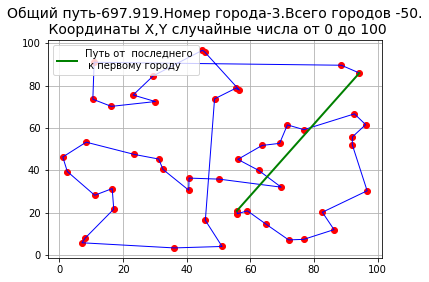

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp,sqrt
n=50;m=100;ib=3;way=[];a=0
X=np.random.uniform(a,m,n)
Y=np.random.uniform(a,m,n)
#X=[10, 10, 100,100 ,30, 20, 20, 50, 50, 85, 85, 75, 35, 25, 30, 47, 50]
#Y=[5, 85, 0,90,50, 55,50,75 ,25,50,20,80,25,70,10,50,100]
#n=len(X)
M = np.zeros([n,n]) # Шаблон матрицы относительных расстояний между пунктами
for i in np.arange(0,n,1):
         for j in np.arange(0,n,1):
                  if i!=j:
                           M[i,j]=sqrt((X[i]-X[j])**2+(Y[i]-Y[j])**2)# Заполнение матрицы
                  else:
                           M[i,j]=float('inf')#Заполнение главной диагонали матрицы           
way.append(ib)
for i in np.arange(1,n,1):
         s=[]
         for j in np.arange(0,n,1):                  
                  s.append(M[way[i-1],j])
         way.append(s.index(min(s)))# Индексы пунктов ближайших городов соседей
         for j in np.arange(0,i,1):
                  M[way[i],way[j]]=float('inf')
                  M[way[i],way[j]]=float('inf')
S=sum([sqrt((X[way[i]]-X[way[i+1]])**2+(Y[way[i]]-Y[way[i+1]])**2) for i in np.arange(0,n-1,1)])+ sqrt((X[way[n-1]]-X[way[0]])**2+(Y[way[n-1]]-Y[way[0]])**2)                      
plt.title('Общий путь-%s.Номер города-%i.Всего городов -%i.\n Координаты X,Y случайные числа от %i до %i'%(round(S,3),ib,n,a,m), size=14)
X1=[X[way[i]] for i in np.arange(0,n,1)]
Y1=[Y[way[i]] for i in np.arange(0,n,1)]    
plt.plot(X1, Y1, color='r', linestyle=' ', marker='o')
plt.plot(X1, Y1, color='b', linewidth=1)   
X2=[X[way[n-1]],X[way[0]]]
Y2=[Y[way[n-1]],Y[way[0]]]
plt.plot(X2, Y2, color='g', linewidth=2,  linestyle='-', label='Путь от  последнего \n к первому городу') 
plt.legend(loc='best')
plt.grid(True)
plt.show()  

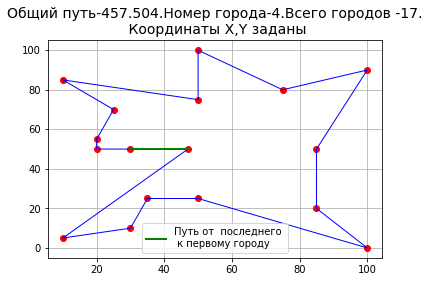

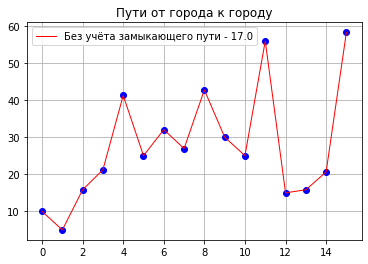

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp,sqrt
n=50;m=100;way=[];a=0
X=np.random.uniform(a,m,n)
Y=np.random.uniform(a,m,n)
X=[10, 10, 100,100 ,30, 20, 20, 50, 50, 85, 85, 75, 35, 25, 30, 47, 50]
Y=[5, 85, 0,90,50, 55,50,75 ,25,50,20,80,25,70,10,50,100]
n=len(X)
RS=[];RW=[];RIB=[]
s=[]
for ib in np.arange(0,n,1):
         M = np.zeros([n,n])
         for i in np.arange(0,n,1):
                  for j in np.arange(0,n,1):
                           if i!=j:
                                    M[i,j]=sqrt((X[i]-X[j])**2+(Y[i]-Y[j])**2)
                           else:
                                    M[i,j]=float('inf')
         way=[]
         way.append(ib)
         for i in np.arange(1,n,1):
                  s=[]
                  for j in np.arange(0,n,1):                  
                           s.append(M[way[i-1],j])
                  way.append(s.index(min(s)))
                  for j in np.arange(0,i,1):
                           M[way[i],way[j]]=float('inf')
                           M[way[i],way[j]]=float('inf')         
         S=sum([sqrt((X[way[i]]-X[way[i+1]])**2+(Y[way[i]]-Y[way[i+1]])**2) for i in np.arange(0,n-1,1)])+ sqrt((X[way[n-1]]-X[way[0]])**2+(Y[way[n-1]]-Y[way[0]])**2)                      
         RS.append(S)
         RW.append(way)
         RIB.append(ib)
S=min(RS)
way=RW[RS.index(min(RS))]
ib=RIB[RS.index(min(RS))]       
X1=[X[way[i]] for i in np.arange(0,n,1)]
Y1=[Y[way[i]] for i in np.arange(0,n,1)]
plt.title('Общий путь-%s.Номер города-%i.Всего городов -%i.\n Координаты X,Y заданы'%(round(S,3),ib,n), size=14)
plt.plot(X1, Y1, color='r', linestyle=' ', marker='o')
plt.plot(X1, Y1, color='b', linewidth=1)   
X2=[X[way[n-1]],X[way[0]]]
Y2=[Y[way[n-1]],Y[way[0]]]
plt.plot(X2, Y2, color='g', linewidth=2,  linestyle='-', label='Путь от  последнего \n к первому городу')
plt.legend(loc='best')
plt.grid(True)
plt.show()  
Z=sqrt((X[way[n-1]]-X[way[0]])**2+(Y[way[n-1]]-Y[way[0]])**2)
Y3=[sqrt((X[way[i+1]]-X[way[i]])**2+(Y[way[i+1]]-Y[way[i]])**2) for i in np.arange(0,n-1,1)]
X3=[i for i in np.arange(0,n-1,1)]
plt.title('Пути от города к городу')
plt.plot(X3, Y3, color='b', linestyle=' ', marker='o')
plt.plot(X3, Y3, color='r',  linewidth=1,  linestyle='-', label='Без учёта замыкающего пути - %s'%str(round(Z,3)))
plt.legend(loc='best')
plt.grid(True)
plt.show ()         

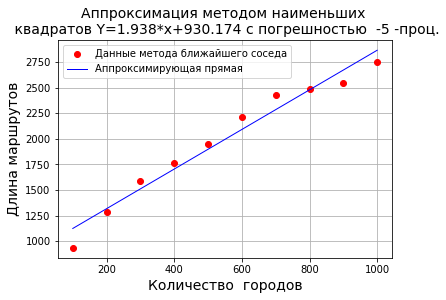

In [87]:
import matplotlib.pyplot as plt
def mnkLIN(x,y):                             
              a=round((len(x)*sum([x[i]*y[i] for i in range(0,len(x))])-sum(x)*sum(y))/(len(x)*sum([x[i]**2 for i in range(0,len(x))])-sum(x)**2),3)
              b=round((sum(y)-a*sum(x))/len(x) ,3)
              y1=[round(a*w+b ,3) for w in x]         
              s=[round((y1[i]-y[i])**2,3) for i in range(0,len(x))]                          
              sko=round((sum(s)/(len(x)-1))**0.5,3)
              p=(sko*len(x)*100)/sum(y1)
              plt.title('Аппроксимация методом наименьших \n квадратов Y=%s*x+%s с погрешностью  -%i -проц.'%(str(a),str(b),int(p)), size=14)
              plt.xlabel('Количество  городов', size=14)
              plt.ylabel('Длина маршрутов', size=14)
              plt.plot(x, y, color='r', linestyle=' ', marker='o', label='Данные метода ближайшего соседа')
              plt.plot(x, y1, color='b',linewidth=1, label='Аппроксимирующая прямая')
              plt.legend(loc='best')
              plt.grid(True)
              plt.show()
y=[933.516, 1282.842, 1590.256, 1767.327 ,1949.975, 2212.668, 2433.955, 2491.954, 2549.579, 2748.672]
x=[100,200,300,400,500,600,	700,800, 900,1000]  
mnkLIN(x,y)       